=== Pelatihan MLPClassifier (Sklearn) ===
Dataset fitur berhasil dimuat. Total 3454 baris.
Data Latih     : 2417 sampel
Data Validasi  : 518 sampel
Data Uji       : 519 sampel

Training model...
Iteration 1, loss = 1.24861860
Iteration 2, loss = 1.12547302
Iteration 3, loss = 1.08478211
Iteration 4, loss = 1.06734089
Iteration 5, loss = 1.05336527
Iteration 6, loss = 1.04236375
Iteration 7, loss = 1.03264273
Iteration 8, loss = 1.02393136
Iteration 9, loss = 1.01598962
Iteration 10, loss = 1.00940502
Iteration 11, loss = 1.00332630
Iteration 12, loss = 0.99839828
Iteration 13, loss = 0.99345049
Iteration 14, loss = 0.98914416
Iteration 15, loss = 0.98628491
Iteration 16, loss = 0.98191135
Iteration 17, loss = 0.97884464
Iteration 18, loss = 0.97590006
Iteration 19, loss = 0.97284883
Iteration 20, loss = 0.96978424
Iteration 21, loss = 0.96673408
Iteration 22, loss = 0.96421459
Iteration 23, loss = 0.96128532
Iteration 24, loss = 0.95895462
Iteration 25, loss = 0.95554670
Iteration 26, 

d:\APLIKASI\anaconda3\envs\aidilju\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


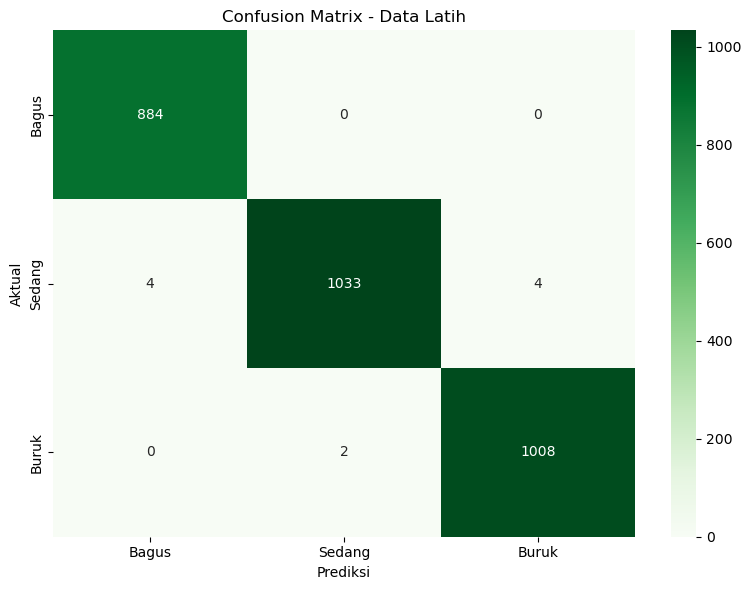

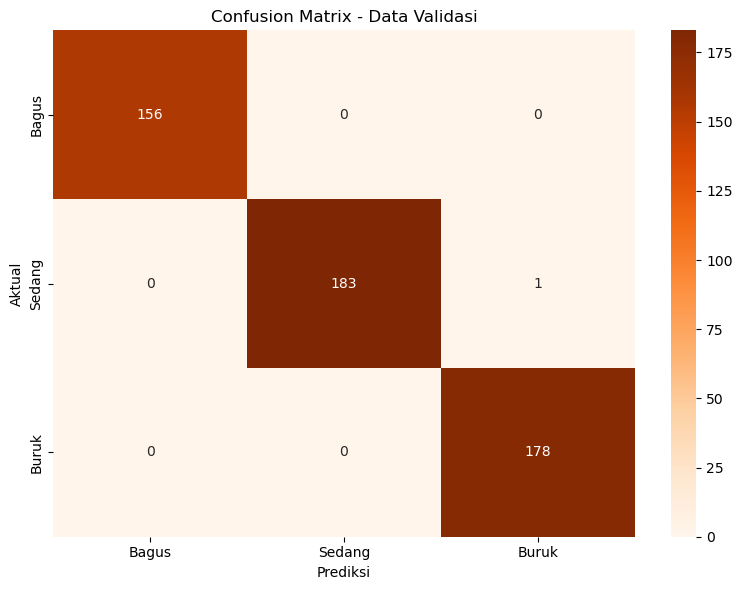

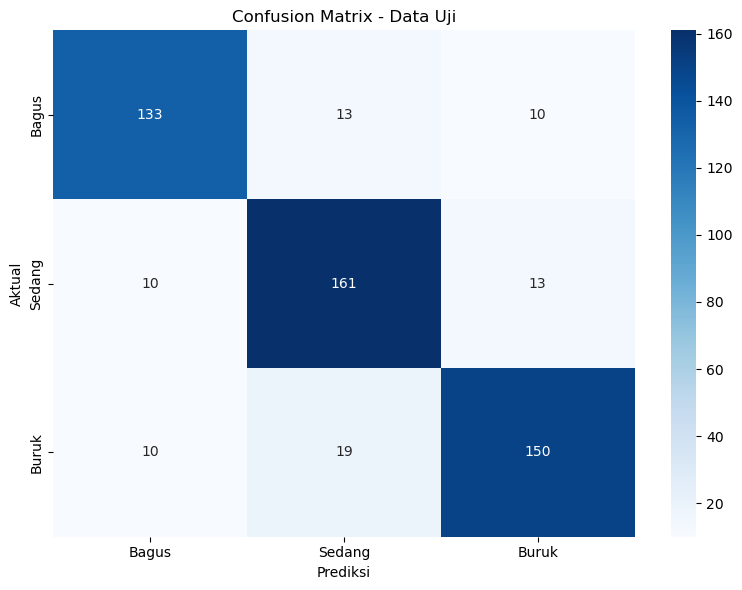

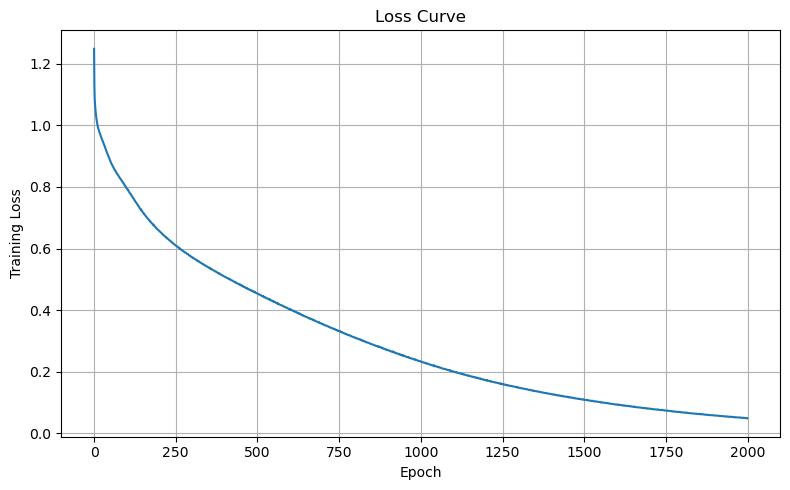

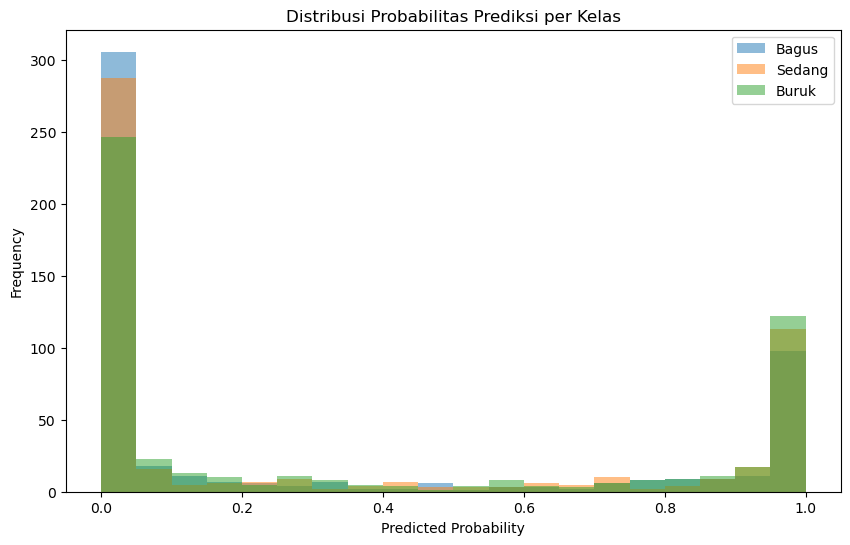


Model, scaler, dan encoder berhasil disimpan.


In [45]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

print("=== Pelatihan MLPClassifier (Sklearn) ===")

# --- [1] PATH ---
BASE_PATH = r"D:\TEKOM THINGS\SEMESTER 5\PCD\TUGAS AKHIR"
CSV_INPUT_FITUR = os.path.join(BASE_PATH, "dataset_fitur_final_v16.csv")

OUTPUT_MODEL_PATH = os.path.join(BASE_PATH, "model_jagung_mlp.joblib") 
OUTPUT_SCALER_PATH = os.path.join(BASE_PATH, "scaler_fitur.joblib")
OUTPUT_ENCODER_PATH = os.path.join(BASE_PATH, "encoder_label.joblib")
OUTPUT_CM_PATH = os.path.join(BASE_PATH, "confusion_matrix_final.png")
OUTPUT_LOSS_PATH = os.path.join(BASE_PATH, "loss_curve_final.png")

# --- [2] Load dataset & pilih fitur ---
df = pd.read_csv(CSV_INPUT_FITUR)

FEATURE_COLUMNS = [
    'h_mean', 'h_std', 's_mean', 's_std', 'v_mean', 'v_std',
    'contrast', 'energy'
]

X = df[FEATURE_COLUMNS]
y_strings = df['kelas']

print(f"Dataset fitur berhasil dimuat. Total {len(df)} baris.")

# --- [3] Label encoding ---
encoder = LabelEncoder()
y = encoder.fit_transform(y_strings)
class_names_default = encoder.classes_

# --- [4] Tentukan urutan kelas yang diinginkan ---
class_order = ['Bagus', 'Sedang', 'Buruk']  
class_order_encoded = encoder.transform(class_order)

# --- [5] Split otomatis stratified 70/15/15 ---
X_latih, X_temp, y_latih, y_temp = train_test_split(
    X, y, 
    test_size=0.30,
    stratify=y,
    random_state=42
)

X_validasi, X_uji, y_validasi, y_uji = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print(f"Data Latih     : {len(X_latih)} sampel")
print(f"Data Validasi  : {len(X_validasi)} sampel")
print(f"Data Uji       : {len(X_uji)} sampel")

# --- [6] Scaling ---
scaler = StandardScaler()
X_latih_scaled = scaler.fit_transform(X_latih)
X_validasi_scaled = scaler.transform(X_validasi)
X_uji_scaled = scaler.transform(X_uji)

# --- [7] Gabungkan latih + validasi untuk full training ---
X_train_full = np.concatenate([X_latih_scaled, X_validasi_scaled])
y_train_full = np.concatenate([y_latih, y_validasi])

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_full)

# --- [8] Model MLP ---
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='tanh',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.0005,
    max_iter=2000,
    early_stopping=False,
    tol=1e-5,
    random_state=42,
    verbose=True
)

print("\nTraining model...")
mlp.fit(X_train_full, y_train_full, sample_weight=sample_weights)

# --- [9] Evaluasi ---
y_pred_train = mlp.predict(X_train_full)
y_pred_valid = mlp.predict(X_validasi_scaled)
y_pred_test  = mlp.predict(X_uji_scaled)

acc_train = accuracy_score(y_train_full, y_pred_train)
acc_valid = accuracy_score(y_validasi, y_pred_valid)
acc_test  = accuracy_score(y_uji, y_pred_test)

print(f"\nAkurasi Data Latih    : {acc_train * 100:.2f}%")
print(f"Akurasi Data Validasi : {acc_valid * 100:.2f}%")
print(f"Akurasi Data Uji      : {acc_test * 100:.2f}%\n")

print("=== Laporan Klasifikasi Data Uji ===")
print(classification_report(
    y_uji, y_pred_test,
    labels=class_order_encoded,
    target_names=class_order
))

# =======================================================
# === [10] Confusion Matrix LATIH / VALIDASI / UJI ===
# =======================================================

# --- [10A] Confusion Matrix - DATA LATIH ---
cm_train = confusion_matrix(y_train_full, y_pred_train, labels=class_order_encoded)
plt.figure(figsize=(8,6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_order, yticklabels=class_order)
plt.title('Confusion Matrix - Data Latih')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH, "cm_latih.png"))
plt.show()

# --- [10B] Confusion Matrix - DATA VALIDASI ---
cm_valid = confusion_matrix(y_validasi, y_pred_valid, labels=class_order_encoded)
plt.figure(figsize=(8,6))
sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_order, yticklabels=class_order)
plt.title('Confusion Matrix - Data Validasi')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH, "cm_validasi.png"))
plt.show()

# --- [10C] Confusion Matrix - DATA UJI ---
cm_test = confusion_matrix(y_uji, y_pred_test, labels=class_order_encoded)
plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_order, yticklabels=class_order)
plt.title('Confusion Matrix - Data Uji')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH, "cm_uji.png"))
plt.show()

# --- [11] Loss Curve ---
plt.figure(figsize=(8,5))
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_LOSS_PATH)
plt.show()

# --- [12] Distribusi probabilitas prediksi ---
y_pred_probs = mlp.predict_proba(X_uji_scaled)
plt.figure(figsize=(10,6))
for i, class_name in enumerate(class_order):
    plt.hist(y_pred_probs[:, i], bins=20, alpha=0.5, label=class_name)
plt.title("Distribusi Probabilitas Prediksi per Kelas")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --- [13] Simpan model ---
joblib.dump(mlp, OUTPUT_MODEL_PATH)
joblib.dump(scaler, OUTPUT_SCALER_PATH)
joblib.dump(encoder, OUTPUT_ENCODER_PATH)
print("\nModel, scaler, dan encoder berhasil disimpan.")


=== TRAIN MLP (TensorFlow) — Versi 2 (Deterministic) ===
Epoch 1/1200


d:\APLIKASI\anaconda3\envs\aidilju\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4427 - loss: 1.0398 - val_accuracy: 0.4807 - val_loss: 1.0241
Epoch 2/1200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4841 - loss: 1.0110 - val_accuracy: 0.4826 - val_loss: 1.0100
Epoch 3/1200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4923 - loss: 0.9969 - val_accuracy: 0.5019 - val_loss: 0.9954
Epoch 4/1200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5126 - loss: 0.9804 - val_accuracy: 0.5019 - val_loss: 0.9803
Epoch 5/1200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5205 - loss: 0.9626 - val_accuracy: 0.5270 - val_loss: 0.9640
Epoch 6/1200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5259 - loss: 0.9460 - val_accuracy: 0.5483 - val_loss: 0.9487
Epoch 7/1200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5548 - loss: 0.9350 - val_accuracy: 0.5618 - val_loss: 0.9365
Epoch 8/1200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5730 - loss: 0.9095 - val_accuracy:

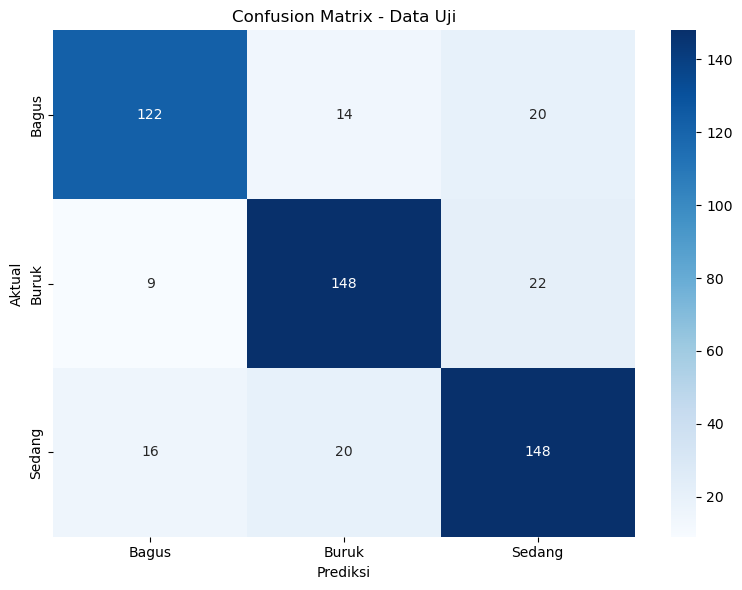

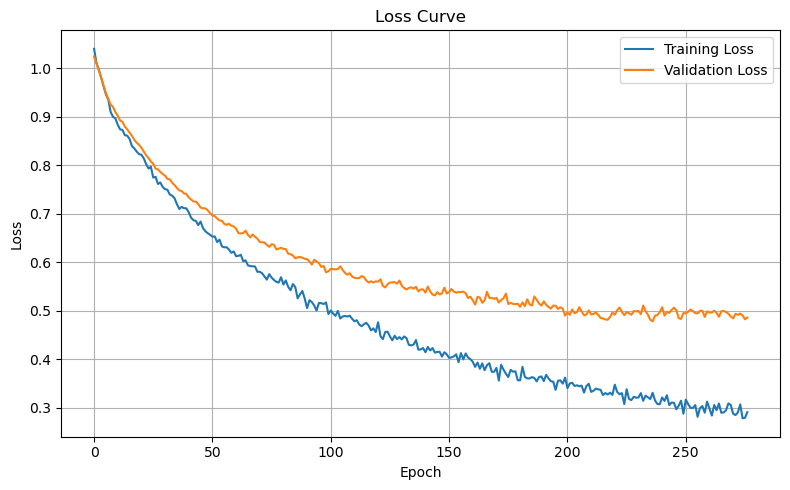

Model TensorFlow Versi 2 berhasil disimpan.


In [ ]:
# ====================================================================================
# ======================= MLP TENSORFLOW — Versi 2 (128→64→32) =======================
# ===== Yang ini hanya backup yang digunakan kode train yang satu pakai SKlearn =====
# ====================================================================================

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ===========================================================
# === SEED LOCK (agar hasil lebih stabil) ===
# ===========================================================
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


print("=== TRAIN MLP (TensorFlow) — Versi 2 (Deterministic) ===")


# ===========================================================
# === Load Dataset ===
# ===========================================================
BASE_PATH = r"D:\TEKOM THINGS\SEMESTER 5\PCD\TUGAS AKHIR"
CSV_INPUT = os.path.join(BASE_PATH, "dataset_fitur_final_v16.csv")

df = pd.read_csv(CSV_INPUT)

FEATURE_COLUMNS = [
    'h_mean', 'h_std', 's_mean', 's_std', 'v_mean', 'v_std',
    'contrast', 'energy'
]

X = df[FEATURE_COLUMNS]
y_strings = df["kelas"]

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(y_strings)
classes = encoder.classes_


# ===========================================================
# === Split 70 / 15 / 15 ===
# ===========================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)


# ===========================================================
# === Scaling ===
# ===========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# ===========================================================
# === MLP MODEL (128 → 64 → 32 + Dropout) ===
# ===========================================================
model = Sequential([
    Dense(128, activation='tanh', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.15),
    Dense(64, activation='tanh'),
    Dropout(0.10),
    Dense(32, activation='tanh'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)


# ===========================================================
# === TRAINING ===
# ===========================================================
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=1200,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


# ===========================================================
# === Evaluasi ===
# ===========================================================
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val_scaled, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\nAkurasi Latih    : {train_acc*100:.2f}%")
print(f"Akurasi Validasi : {val_acc*100:.2f}%")
print(f"Akurasi Uji      : {test_acc*100:.2f}%\n")


# ===========================================================
# === Confusion Matrix Uji ===
# ===========================================================
y_pred_test = np.argmax(model.predict(X_test_scaled), axis=1)
cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Data Uji")
plt.ylabel("Aktual")
plt.xlabel("Prediksi")
plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH, "tf_cm_uji.png"))
plt.show()


# ===========================================================
# === Loss Curve ===
# ===========================================================
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH, "tf_loss_curve.png"))
plt.show()


# ===========================================================
# === Simpan Model ===
# ===========================================================
model.save(os.path.join(BASE_PATH, "tf_mlp_v2.h5"))
joblib.dump(scaler, os.path.join(BASE_PATH, "tf_scaler.joblib"))
joblib.dump(encoder, os.path.join(BASE_PATH, "tf_encoder.joblib"))

print("Model TensorFlow Versi 2 berhasil disimpan.")
